<a href="https://colab.research.google.com/github/okbayby22/Track/blob/master/Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/okbayby22/Track


fatal: destination path 'Track' already exists and is not an empty directory.


In [ ]:
!ls track

ls: cannot access 'track': No such file or directory


In [5]:
!ls Track

driving_log.csv  IMG


In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [33]:
datadir = 'Track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\HUY\Documents\Seft-Driving\Data\IMG\center_2020_06_17_20_14_56_292.jpg,C:\Users\HUY\Documents\Seft-Driving\Data\IMG\left_2020_06_17_20_14_56_292.jpg,C:\Users\HUY\Documents\Seft-Driving\Data\IMG\right_2020_06_17_20_14_56_292.jpg,-0.40,1.0,0.0,10.74195
1,C:\Users\HUY\Documents\Seft-Driving\Data\IMG\center_2020_06_17_20_14_56_360.jpg,C:\Users\HUY\Documents\Seft-Driving\Data\IMG\left_2020_06_17_20_14_56_360.jpg,C:\Users\HUY\Documents\Seft-Driving\Data\IMG\right_2020_06_17_20_14_56_360.jpg,0.00,1.0,0.0,11.35672
2,C:\Users\HUY\Documents\Seft-Driving\Data\IMG\center_2020_06_17_20_14_56_430.jpg,C:\Users\HUY\Documents\Seft-Driving\Data\IMG\left_2020_06_17_20_14_56_430.jpg,C:\Users\HUY\Documents\Seft-Driving\Data\IMG\right_2020_06_17_20_14_56_430.jpg,0.00,1.0,0.0,12.00370
3,C:\Users\HUY\Documents\Seft-Driving\Data\IMG\center_2020_06_17_20_14_56_502.jpg,C:\Users\HUY\Documents\Seft-Driving\Data\IMG\left_2020_06_17_20_14_56_502.jpg,C:\Users\HUY\Documents\Seft-Driving\Data\IMG\right_2020_06_17_20_14_56_502.jpg,0.00,1.0,0.0,13.00690
4,C:\Users\HUY\Documents\Seft-Driving\Data\IMG\center_2020_06_17_20_14_56_569.jpg,C:\Users\HUY\Documents\Seft-Driving\Data\IMG\left_2020_06_17_20_14_56_569.jpg,C:\Users\HUY\Documents\Seft-Driving\Data\IMG\right_2020_06_17_20_14_56_569.jpg,-0.15,1.0,0.0,13.71006


In [34]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_06_17_20_14_56_292.jpg,left_2020_06_17_20_14_56_292.jpg,right_2020_06_17_20_14_56_292.jpg,-0.40,1.0,0.0,10.74195
1,center_2020_06_17_20_14_56_360.jpg,left_2020_06_17_20_14_56_360.jpg,right_2020_06_17_20_14_56_360.jpg,0.00,1.0,0.0,11.35672
2,center_2020_06_17_20_14_56_430.jpg,left_2020_06_17_20_14_56_430.jpg,right_2020_06_17_20_14_56_430.jpg,0.00,1.0,0.0,12.00370
3,center_2020_06_17_20_14_56_502.jpg,left_2020_06_17_20_14_56_502.jpg,right_2020_06_17_20_14_56_502.jpg,0.00,1.0,0.0,13.00690
4,center_2020_06_17_20_14_56_569.jpg,left_2020_06_17_20_14_56_569.jpg,right_2020_06_17_20_14_56_569.jpg,-0.15,1.0,0.0,13.71006


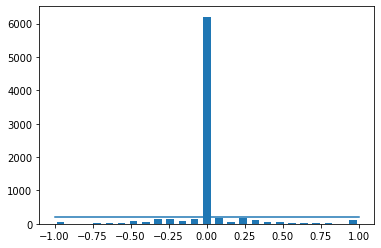

In [35]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 7827
removed: 6007
remaining: 1820


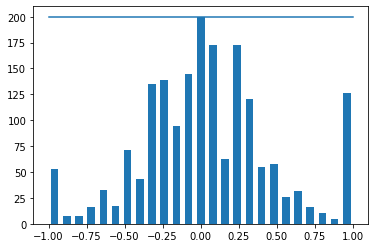

In [36]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [37]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

center      center_2020_06_17_20_14_56_569.jpg
left        left_2020_06_17_20_14_56_569.jpg  
right       right_2020_06_17_20_14_56_569.jpg 
steering   -0.15                              
throttle    1                                 
reverse     0                                 
speed       13.7101                           
Name: 4, dtype: object
Training Samples: 4368
Valid Samples: 1092


Text(0.5, 1.0, 'Validation set')

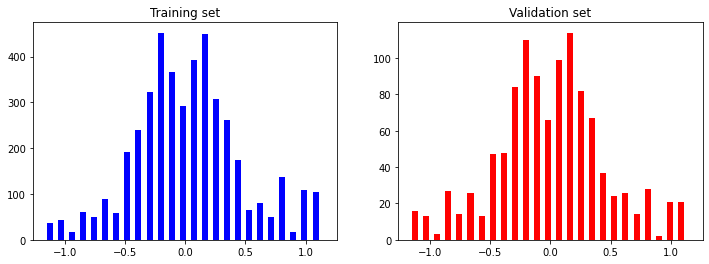

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [48]:
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'preprocessed Image')

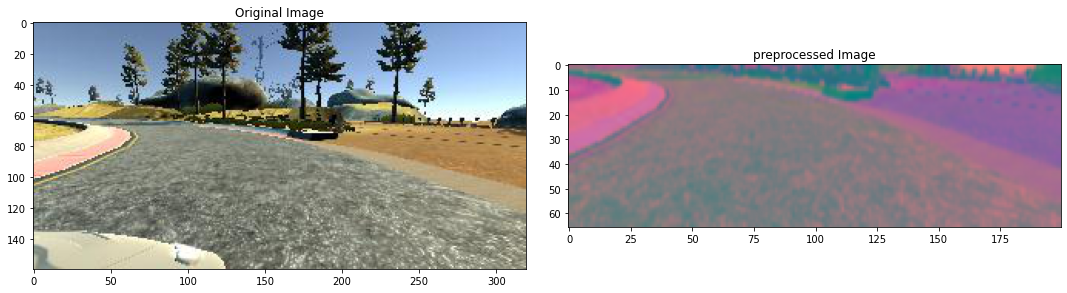

In [49]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
preprocessed_img = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(preprocessed_img)
axs[1].set_title('preprocessed Image')


In [50]:
X_train=np.array(list(map(img_preprocess,X_train)))
X_valid=np.array(list(map(img_preprocess,X_valid)))

(4368, 66, 200, 3)


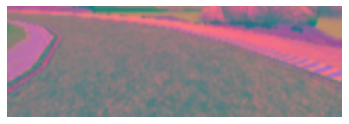

In [52]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis("off")
print(X_train.shape)

In [65]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='relu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))

  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [66]:
model=nvidia_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)             

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="relu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), ac

In [67]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid,y_valid),batch_size=100,verbose=1,shuffle=1)
                                

Train on 4368 samples, validate on 1092 samples
Epoch 1/20
4368/4368 [==============================] - 30s 7ms/step - loss: 0.3064 - val_loss: 0.1947
Epoch 2/20
4368/4368 [==============================] - 30s 7ms/step - loss: 0.1930 - val_loss: 0.1703
Epoch 3/20
4368/4368 [==============================] - 30s 7ms/step - loss: 0.1815 - val_loss: 0.1622
Epoch 4/20
4368/4368 [==============================] - 30s 7ms/step - loss: 0.1616 - val_loss: 0.1387
Epoch 5/20
4368/4368 [==============================] - 30s 7ms/step - loss: 0.1482 - val_loss: 0.1204
Epoch 6/20
4368/4368 [==============================] - 30s 7ms/step - loss: 0.1389 - val_loss: 0.1159
Epoch 7/20
4368/4368 [==============================] - 30s 7ms/step - loss: 0.1311 - val_loss: 0.1182
Epoch 8/20
4368/4368 [==============================] - 30s 7ms/step - loss: 0.1333 - val_loss: 0.1171
Epoch 9/20
4368/4368 [==============================] - 30s 7ms/step - loss: 0.1266 - val_loss: 0.0939
Epoch 10/20
4368/4368 [==

Text(0.5, 0, 'Epoch')

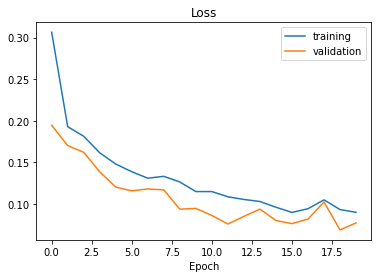

In [68]:
 plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [69]:
model.save('model.h5')

In [70]:
from google.colab import files
files.download('model.h5')